In [38]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
from pysindy import EnsembleOptimizer
plt.style.use('ggplot')
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})


In [39]:
exp_data = LorenzExp
initial_state = jnp.array([ -5, 0., 5])
initial_state = jnp.array([ -8,8,27.])
dt = 0.05
noise_var = 4.
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

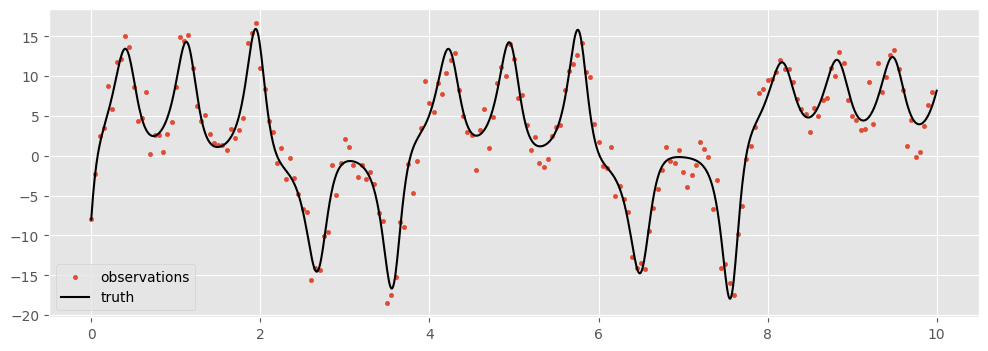

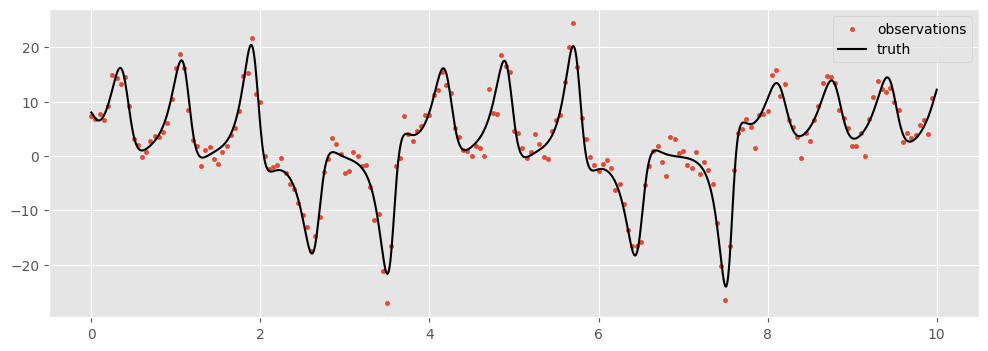

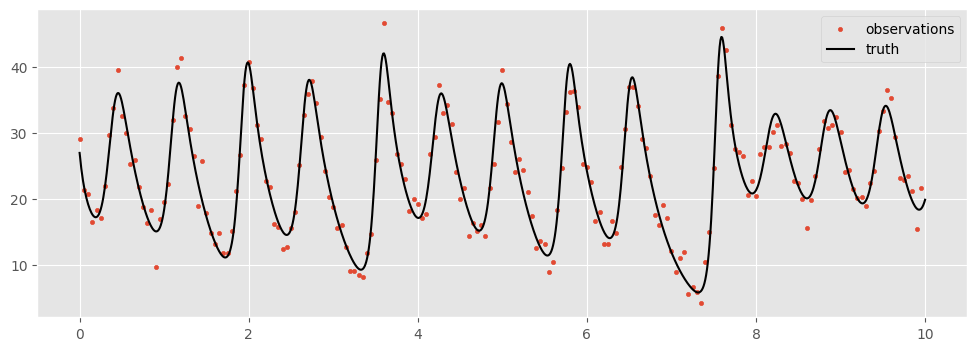

In [40]:
t_grid = jnp.linspace(t0,t1,1001)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth',c='black')
    plt.legend()
    plt.show()


In [41]:
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.5,alpha = 0.01)
    )
# sparsifier = pySindySparsifier(EnsembleOptimizer(STLSQ(threshold = 0.5,alpha = 0.1),bagging=True,n_models = 100))

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )


optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    expdata.t_train,
    expdata.x_train,
    t_colloc = expdata.t_colloc,
    w_colloc = expdata.w_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


{'show_progress': True, 'sigma2_est': Array(3.84053026, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 1.576e+07, gradnorm = 4.292e+08, alpha = 4.167, improvement_ratio = 0.9716
Iteration 1, loss = 1.091e+07, gradnorm = 7.994e+08, alpha = 4.167, improvement_ratio = 0.308
Iteration 2, loss = 2.767e+06, gradnorm = 1.366e+09, alpha = 4.167, improvement_ratio = 0.7465
Iteration 3, loss = 7.431e+05, gradnorm = 1.905e+08, alpha = 4.167, improvement_ratio = 0.7317
Iteration 4, loss = 5.457e+04, gradnorm = 1.998e+08, alpha = 3.472, improvement_ratio = 0.928
Iteration 5, loss = 4.047e+04, gradnorm = 6.993e+07, alpha = 3.472, improvement_ratio = 0.2637
Iteration 100, loss = 1.078e+03, gradnorm = 0.1376, alpha = 0.001969, improvement_ratio = 1.018
Line Search Failed!
Final Iteration Results
Iteration 131, loss = 1.078e+03, gradnorm = 0.2025, alpha = 3.659e+05, improvement_ratio = -9.235e+03
Model after smooth warm start
(x)' = 1.878 1 + -10.240 x + 10.467 y + -0.581 z + -0.393 x^2 + 0.517 x y + 0.004 x z + -0.195 y^2 + -0.017 y z + 0.029 z^2
(y)' = -24.547 1 + 21.525 x + 4.524 

In [42]:
model.print()

(x)' = -9.607 x + 9.689 y
(y)' = 29.122 x + -1.239 y + -1.033 x z
(z)' = -2.624 z + 0.999 x y


In [43]:
# model.optimizer.solver_settings

In [44]:
print(model)


--------Trajectory Model--------

MLE Adapted Cholesky Parametrized RKHS Trajectory Model
kernel: 188.823 + 71.49Matern(5,0.15)
derivative_orders: (0, 1)
nugget: 1e-08


--------Feature Library---------
degree: 2
include_bias: True
include_interaction: True
interaction_only: False
order: C

--------Optimizer Setup--------

Alternating Active Set Optimizer
beta_reg: 0.001,
sparsifier: STLSQ(alpha=0.01, threshold=0.5)
data_weight: 1.0
colloc_weight: 100000.0




In [45]:
expdata.print(precision=5)

(x)' = -10.00000 x + 10.00000 y
(y)' = 28.00000 x + -1.00000 y + -1.00000 x z
(z)' = -2.66667 z + 1.00000 x y


In [46]:
model.print(precision=5)

(x)' = -9.60653 x + 9.68942 y
(y)' = 29.12213 x + -1.23898 y + -1.03268 x z
(z)' = -2.62402 z + 0.99903 x y


In [47]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
# plt.figure(figsize=(12,8))
# for dim in range(3):
#     plt.subplot(3,1,dim+1)
#     plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'Observations',s = 9)
#     plt.plot(t_grid,true_states[:,dim],label = 'True Trajectory',c='black')
#     plt.plot(t_grid,state_preds[:,dim],label = 'State Estimates',c ='blue',alpha = 0.3,lw = 5)
#     if dim ==0:
#         plt.legend()
#     plt.ylabel(f"$x_{dim+1}(t)$")
# plt.savefig("figures/lorenz_prelim.pdf")

In [48]:
import diffrax
from data.lorenz import lorenz_system


true_system = jax.jit(lorenz_system)

jit_lor_pred = jax.jit(model.predict)


def learned_system(t,x,args):
    return jit_lor_pred(x)



def simulate_sol(y0,system, t0=expdata.t0,t1=expdata.t1,dt=expdata.dt,t_eval = expdata.t_true, args = None):
    term = diffrax.ODETerm(system)
    solver = diffrax.Tsit5()

    save_at = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0 = t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args = args,
        saveat=save_at,
        max_steps=int(10*(t1-t0)/dt)
    )

    return jax.vmap(sol.evaluate)(t_eval)


In [49]:
lorenz_args = (expdata.sigma,expdata.rho, expdata.beta)
t_extend = jnp.linspace(10,15,501)

x_true_extend = simulate_sol(true_states[-1],system=true_system,t0=t_extend[0],t1=t_extend[-1], t_eval=t_extend, args=lorenz_args)
x_sim_extend = simulate_sol(true_states[-1],system=learned_system,t0=t_extend[0],t1=t_extend[-1], t_eval=t_extend,)

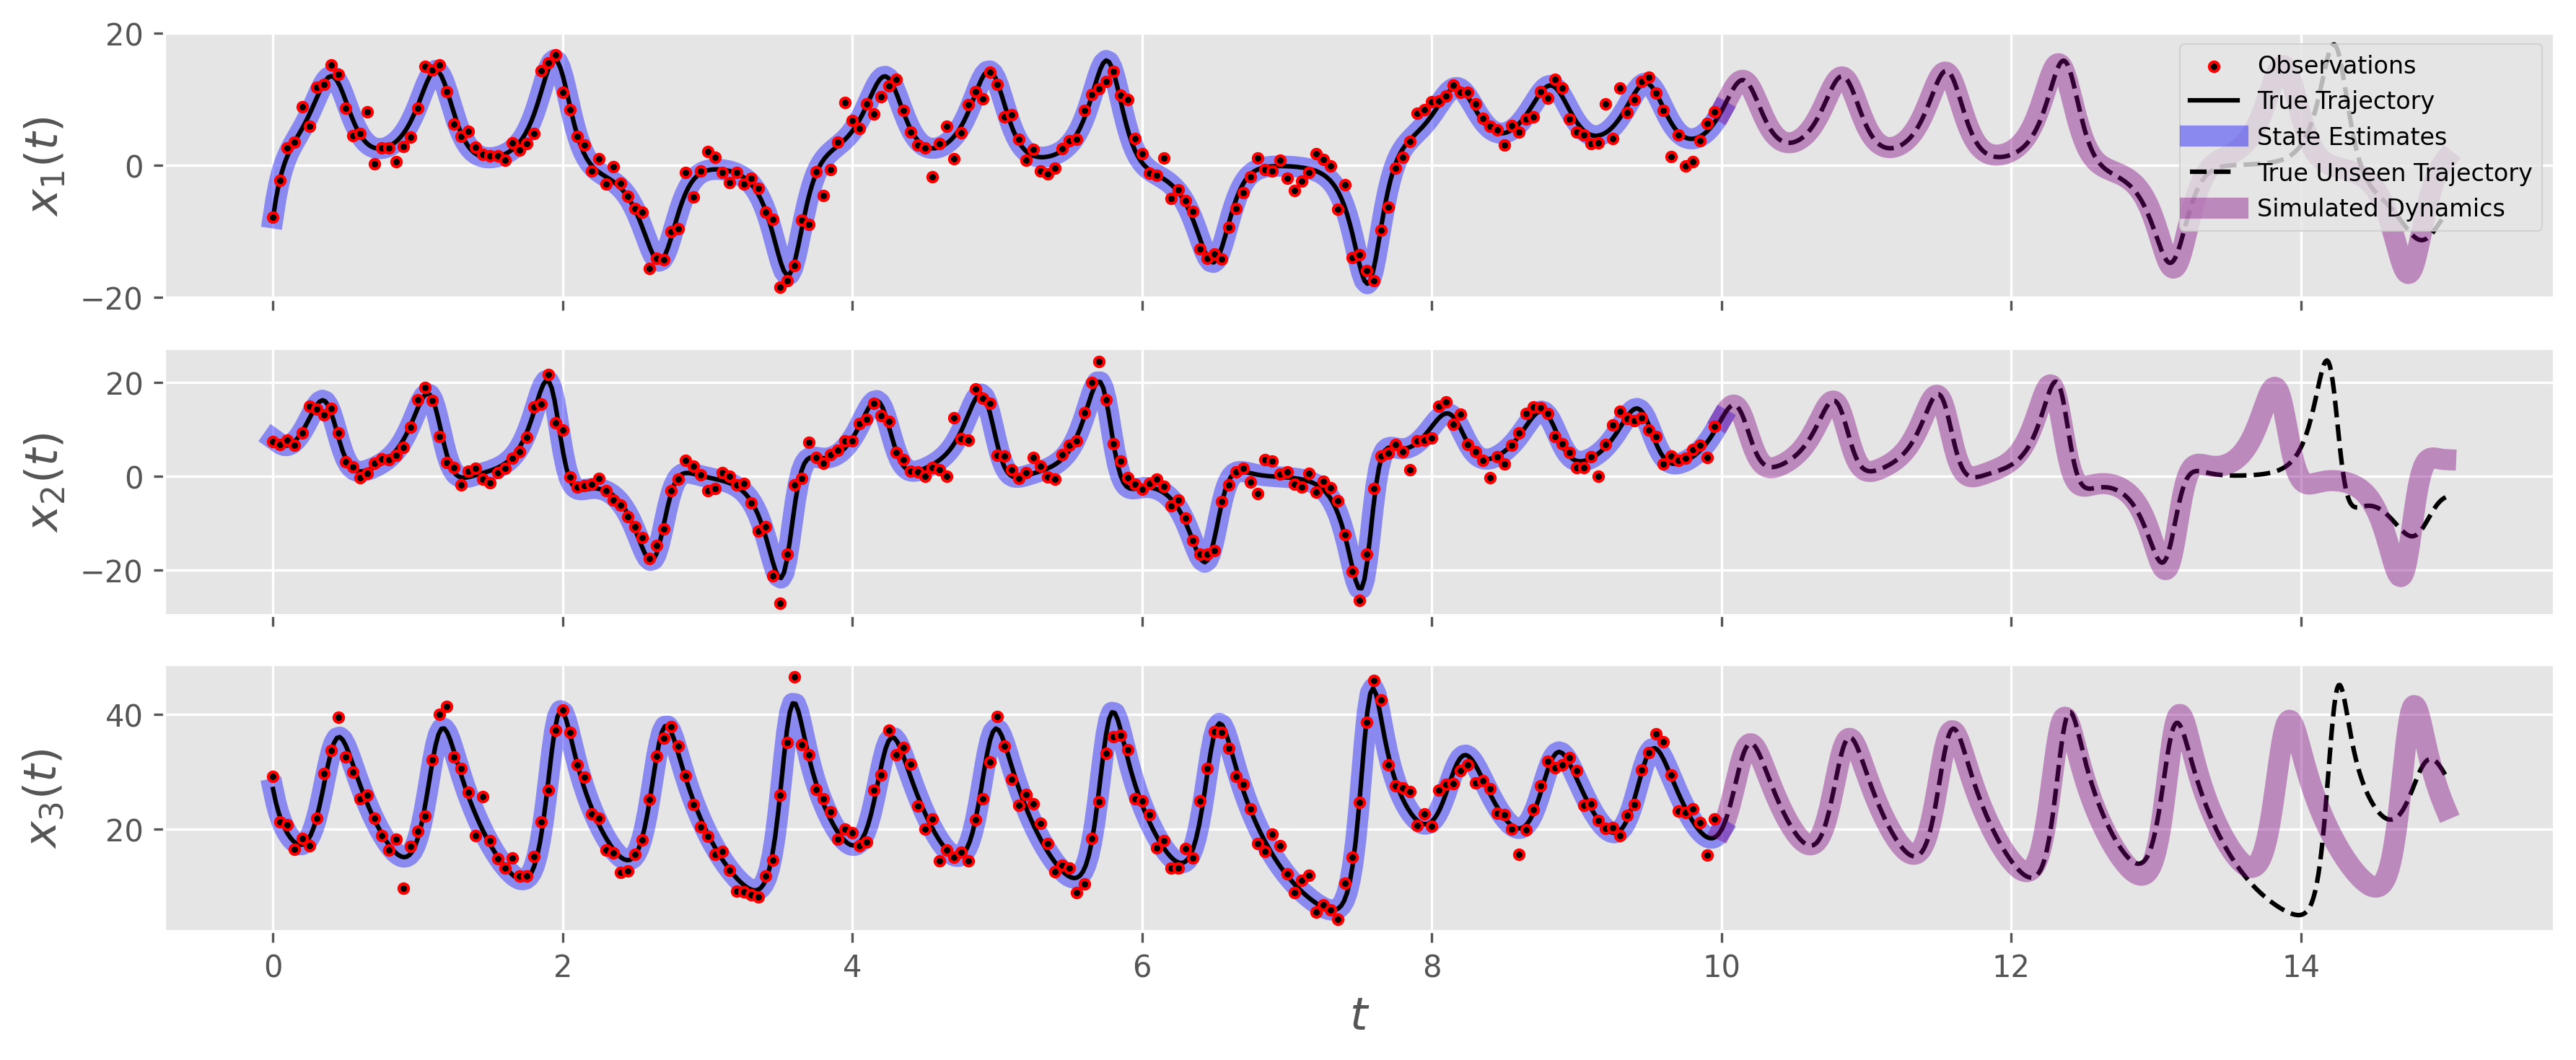

In [56]:
fig, axs  = plt.subplots(3,1, figsize=(12,5),sharex=True,dpi=300)

axs = axs.flatten()
lw=1.5

y_labels = [r"$x_1(t)$", r"$x_2(t)$", r"$x_3(t)$"]
for idx, ax in enumerate(axs):
    ax.scatter(expdata.t_train,expdata.x_train[:,idx],zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=10,lw=1.)
    ax.plot(t_grid,true_states[:,idx],label = 'True Trajectory',c='black',zorder=2)
    ax.plot(t_grid,true_states[:,idx],label='State Estimates', linestyle='-',c='blue', alpha=0.4,lw=7,zorder=1)

    # extended
    
    ax.plot(t_extend, x_true_extend[:,idx],c='black', linestyle='--', label='True Unseen Trajectory')
    ax.plot(t_extend, x_sim_extend[:,idx],c='purple',alpha=0.4, lw=7,linestyle='-',label='Simulated Dynamics')

    if idx> 1:
        ax.set_ylabel(y_labels[idx],size=15, rotation = 90,labelpad=13)
    else:
        ax.set_ylabel(y_labels[idx],size=15, rotation = 90)

    if idx == 0:
        ax.legend(loc ='upper right',prop={'size':8})
    if idx == len(y_labels) - 1:
        ax.set_xlabel(r"$t$", size=15)

plt.tight_layout()
plt.savefig("figures/lorenz.pdf")
plt.show()

In [57]:
expdata.x_train.shape

(200, 3)

# Metrics

In [51]:
noise_std = jnp.sqrt(noise_var)
jnp.mean(noise_std / jnp.std(true_states, axis=0)).item(), noise_std.item()

(0.24603985500928177, 2.0)

In [52]:
true_theta = expdata.true_coeff.T

In [53]:
mse = jnp.mean(jnp.mean((true_states - state_preds)**2, axis=0) / jnp.var(true_states, axis=0))
rmse = jnp.sqrt(mse)
mae = jnp.linalg.norm(true_theta - model.theta) / jnp.linalg.norm(true_theta)

In [54]:
mse.item(), rmse.item(), mae.item()

(0.0005538705905481829, 0.023534455390940807, 0.03974597448483692)

In [18]:
import numpy as np
import pysindy as ps

from pysindy import SmoothedFiniteDifference
from pysindy import STLSQ
from pysindy import EnsembleOptimizer


t_train = np.array(expdata.t_train)
x_train = np.array(expdata.x_train)
feature_library = ps.PolynomialLibrary(degree =2)

optimizer = EnsembleOptimizer(STLSQ(threshold = 0.5,alpha = 0.01),bagging=True,n_models = 200)
optimizer = STLSQ(threshold = 0.5,alpha = 0.01)
ps_model = ps.SINDy(
    differentiation_method=SmoothedFiniteDifference(),
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y","z"],
)
ps_model.fit(x_train,t_train)
ps_model.print()
print()
expdata.print()

(x)' = -2.763 1 + -8.219 x + 8.704 y
(y)' = 1.289 1 + 17.851 x + 0.960 y + -0.741 x z
(z)' = -3.223 1 + -2.264 z + 0.969 x y

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


In [19]:
ps_model

,optimizer,STLSQ(alpha=0...threshold=0.5)
,feature_library,PolynomialLibrary()
,differentiation_method,SmoothedFiniteDifference()
,feature_names,"['x', 'y', ...]"
,t_default,1
,discrete_time,False
,degree,2
,include_interaction,True
,interaction_only,False
,include_bias,True
,order,'C'


In [20]:
print(ps_model.feature_library._repr_html_())

<style>#sk-container-id-2 {
  /* Definition of color scheme common for light and dark mode */
  --sklearn-color-text: #000;
  --sklearn-color-text-muted: #666;
  --sklearn-color-line: gray;
  /* Definition of color scheme for unfitted estimators */
  --sklearn-color-unfitted-level-0: #fff5e6;
  --sklearn-color-unfitted-level-1: #f6e4d2;
  --sklearn-color-unfitted-level-2: #ffe0b3;
  --sklearn-color-unfitted-level-3: chocolate;
  /* Definition of color scheme for fitted estimators */
  --sklearn-color-fitted-level-0: #f0f8ff;
  --sklearn-color-fitted-level-1: #d4ebff;
  --sklearn-color-fitted-level-2: #b3dbfd;
  --sklearn-color-fitted-level-3: cornflowerblue;

  /* Specific color for light theme */
  --sklearn-color-text-on-default-background: var(--sg-text-color, var(--theme-code-foreground, var(--jp-content-font-color1, black)));
  --sklearn-color-background: var(--sg-background-color, var(--theme-background, var(--jp-layout-color0, white)));
  --sklearn-color-border-box: var(--sg-tex

In [21]:
# Same library terms as before
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]


In [22]:
ode_lib = ps.WeakPDELibrary(
    function_library=feature_library,
    spatiotemporal_grid=t_train,
    is_uniform=True,
    K=500,
)
optimizer = EnsembleOptimizer(
    STLSQ(threshold = 0.3,alpha = 0.005),
    bagging=True,
    n_models = 200)

# sr3_optimizer = ps.SR3(
#     reg_weight_lam=0.5,
#     regularizer="l0",
#     max_iter=100000,
#     normalize_columns=True,
#     tol=1e-1
# )
ps_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
ps_model.fit(x_train,t_train)
ps_model.print()


/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/pysindy/feature_library/weak_pde_library.py:177: UserWarning: is_uniform and periodic have been deprecated.in favor of differetiation_method and diff_kwargs.
  warnings.warn(
/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/pysindy/utils/axes.py:126: AxesWarning: 2 axes labeled for array with 1 axes
  warnings.warn(


(x0)' = -3.159 1 + -9.245 x0 + 9.510 x1
(x1)' = -1.636 1 + 21.790 x0 + 1.075 x1 + -0.847 x0 x2
(x2)' = -2.513 x2 + 0.963 x0 x1


In [23]:
model.coefficients()

AttributeError: 'JSINDyModel' object has no attribute 'coefficients'